# **Advancements in XAI Evaluation: A Practical Tutorial using `Quantus` (and `MetaQuantus`**)

**Author:** Anna Hedström, PhD Candidate, TU Berlin and ATB Potsdam

**Contact:** <anna.hedstroem@tu-berlin.de>

**Venue:** SFB 1294, Data Assimilation, Spring School

**Date:** March, 2023

**Abstract:** In recent years, there has been a growing interest in eXplainable AI (XAI) techniques, resulting in an abundance of methods and toolboxes available for XAI researchers and ML practitioners. However, until recently, the topic of XAI evaluation has been greatly neglected, leading to confusion regarding the performance of XAI methods and their suitability for specific conditions. In this tutorial, as a first part, we will take an in-depth look at some of the most recent developments in XAI evaluation and in particular, give a demonstration of how to perform XAI evaluation using the open-source library Quantus. In the second part of the tutorial, we will define and address the problem of meta-evaluation in XAI (i.e., the process of evaluating the evaluation method itself) which arises as we select and quantitatively compare explanation methods for a given model, dataset and task—where the use of multiple XAI metrics or evaluation techniques oftentimes lead to conflicting results. In this part, we will use the library MetaQuantus to characterise the performance of different XAI metrics and moreover, help select and identify a reliable metric for our chosen explainability context.

**Related Papers:** 
* [Quantus: An Explainable AI Toolkit for Responsible Evaluation of Neural Network Explanations and Beyond](https://jmlr.org/papers/v24/22-0142.html) by Hedström et al., 2022
* [The Meta-Evaluation Problem in Explainable AI:
Identifying Reliable Estimators with MetaQuantus](https://arxiv.org/abs/2302.07265) by Hedström et al., 2023


<div align="center">
  <img src="https://raw.githubusercontent.com/understandable-machine-intelligence-lab/Quantus/main/viz.png" width="540"/>
</div>

**Instructions:** For this exercise, we work in a `Google Colab` environment. It is also possible to run the notebook using a simple `Jupyter  Notebook` environment.
___


## Table of Contents

* [1. Overview](#agenda)
* [2. Installation Prerequisites](#software)
* [3. Preliminaries](#prel)
    * [3.1 Load data](#data)
    * [3.2 Load models](#data)
    * [3.3 Load explanations](#xai-methods)
* [4. Introduction to Quantus](#quantus)
    * [4.1 XAI metrics](#xai-metrics)
    * [4.2 Large-scale evaluation](#large-scale)
* [5. Introduction to MetaQuantus](#metaquantus)
    * [5.1 Load estimators](#estimators)
    * [5.2 Define test suite](#test-suire)
    * [5.3 Meta-evaluate methods](#me-methods)
* [6. References](#references)



<a name="agenda"></a>
## 1) Overview

* We set out multiple goals for this tutorial (ii) to familiarise the audience with advancements in XAI evaluation (ii) to introduce two open-source software libraries: `Quantus` and `MetaQuantus` and (iii) run a real-world image classification example.
* To follow the tutorial, some basic knowledge of Explainable AI, especially with respect to local XAI methods is necessary.
* For out-of-scope, we do not showcase how `Quantus` can be used with `Tensorflow` and with other tasks/ data domains such as time-series, tabular or NLP data. We do not discuss global explanation methods.

<a name="software"></a>
## 2) Installation prerequisites

Import the main libraries `Quantus` and `MetaQuantus` and some supportive libraries.

In [ ]:
!pip install metaquantus quantus torch torchvision --quiet

In [ ]:
# Imports.
import quantus
import metaquantus
import glob
import gc
import warnings
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Enable GPU. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Notebook settings.
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
sns.set() 

<a name="preliminaries"></a>
## 3) Preliminaries

For the purpose of demonstration, in this exercise, we rely on a image-classification task with `PyTorch`. That being said, `Quantus` and `MetaQuatus` do support other ML frameworks such as `Tensorflow` and data domains e.g., time-series, tabular data and some NLP support.


<a name="data"></a>
### 3.1 Load data

We have prepared a small subset of ImageNet images (to download the full dataset, please find instructions here: <https://image-net.org/download.php>). The following will load inputs `x_batch`, labels `y_batch` and segmentation masks `s_batch`.

In [ ]:
!pip install gdown --quiet
!gdown https://drive.google.com/drive/folders/1ZmIkqvnt8_wXU3dLBWS9i88l-spS_FU1 --folder --quiet
!ls

assets	sample_data


In [ ]:
#@title 3.1.1 ImageNet class indices names
%%capture
CLASSES = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}


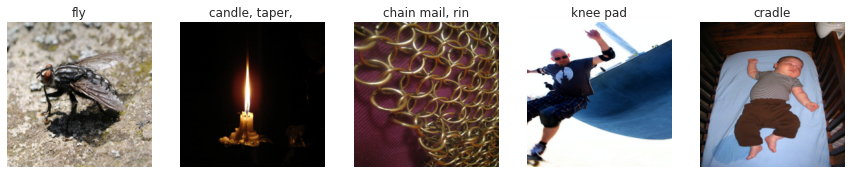

In [ ]:
# Load test data and make loaders.
nr_samples = 15

assets = np.load("assets/imagenet_test_set.npy", allow_pickle=True).item()
x_batch = assets["x_batch"][:nr_samples]
y_batch = assets["y_batch"][:nr_samples]
s_batch = assets["s_batch"].reshape(-1, 1, 224, 224)[:nr_samples]

# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2)))
for i in range(nr_images):
    image = (np.moveaxis(quantus.denormalise(x_batch[i], mean=np.array([0.485, 0.456, 0.406]), 
                                             std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8)
    axes[i].imshow(image, vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"{CLASSES[y_batch[i]][:15]}")
    axes[i].axis("off")
plt.show()

<a name="models"></a>
### 3.2 Load models

Since the focus of this tutorial is not on model training but XAI evalution, we load pre-trained models with `torchvision` library.

In [ ]:
# Pick your model!
models = torchvision.models.list_models(module=torchvision.models)
models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [ ]:
# Load pre-trained model of choice.
model = torchvision.models.resnet18(pretrained=True)

<a name="xai-methods"></a>
### 3.3 Load explanations

Before introducing `Quantus`, we need some XAI methods that we aim at evaluate. 

Generating explanations XAI evaluation with `Quantus` can be done in multiple ways, for example:
* Using XAI libraries such as `captum` or `innvestigate`
* Realy on `Quantus` built-in XAI functionality (offers 20+ XAI methods)
* Build own explainer methods

In this example, we rely on `Quantus` built-in XAI and build our own customised explainer functions.


In [ ]:
# For Tensorflow, quantus.AVAILABLE_XAI_METHODS_TF can be used.
quantus.AVAILABLE_XAI_METHODS_CAPTUM

['GradientShap',
 'IntegratedGradients',
 'DeepLift',
 'DeepLiftShap',
 'InputXGradient',
 'Saliency',
 'FeatureAblation',
 'Deconvolution',
 'FeaturePermutation',
 'Lime',
 'KernelShap',
 'LRP',
 'Gradient',
 'Occlusion',
 'LayerGradCam',
 'GuidedGradCam',
 'LayerConductance',
 'LayerActivation',
 'InternalInfluence',
 'LayerGradientXActivation',
 'Control Var. Sobel Filter',
 'Control Var. Constant',
 'Control Var. Random Uniform']

In [ ]:
# Generate Saliency explanations with Quantus.
a_batch = quantus.explain(model=model, inputs=x_batch, targets=y_batch, **{"method:": "Saliency", "device": device})

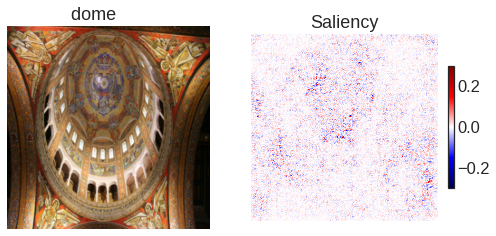

In [ ]:
def plot_explanation(index: int):
    """Plot an explanation for an input sample."""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    image = (np.moveaxis(quantus.denormalise(x_batch[index], 
                                             mean=np.array([0.485, 0.456, 0.406]), 
                                             std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8)
    axes[0].imshow(image, vmin=0.0, vmax=1.0)
    axes[0].title.set_text(f"{CLASSES[y_batch[index]]:10}")
    axes[0].axis("off");
    attr_ = axes[1].imshow(a_batch[index].reshape(224, 224), cmap="seismic") 
    fig.colorbar(attr_, fraction=0.03, pad=0.05); 
    axes[1].title.set_text("Saliency")
    axes[1].axis("off")
    plt.show()

# Plot a random explanation sample!
plot_explanation(index=np.random.randint(0, len(x_batch)-1))

In this example, we create a new explanation function following the method FusionGrad by [NoiseGrad — Enhancing Explanations by Introducing Stochasticity to Model Weights](https://ojs.aaai.org/index.php/AAAI/article/view/20561) by Bykov et al., 2022.



In [ ]:
#@title 3.3.1 Write own explainer
%%capture
import copy
import gc
import numpy as np
import torch
import quantus
from captum.attr import Saliency


def fusiongrad_explainer(model, inputs, targets, **kwargs) -> np.ndarray:
    """Implementation of FusionGrad by Bykov et al., 2022."""

    # PyTorch and general processing.
    device = kwargs.get("device", "cpu")
    img_size = kwargs.get("img_size", 224)
    nr_channels = kwargs.get("nr_channels", 3)
    
    # Post-processng attribution.
    abs = kwargs.get("abs", False)
    normalise = kwargs.get("normalise", False)
    normalise_func = kwargs.get("normalise_func", quantus.normalise_by_negative)
    
    # FusionGrad specific.
    posterior_mean = kwargs.get("posterior_mean", copy.deepcopy(model.to(device).state_dict()))
    mean, std = kwargs.get("mean, std", (1.0, 0.75))
    sg_mean, sg_std = kwargs.get("sg_mean, sg_std", (0.0, 0.25))
    n, m = kwargs.get("n, m", (10, 10))

    # Save the posterior mean, copy of the mode.
    #posterior_mean = copy.deepcopy(model.to(device).state_dict())

    def _sample(model, posterior_mean, std, distribution=None, noise_type="multiplicative"):
        """Implementation to sample a model."""

        # Load model params.
        model.load_state_dict(posterior_mean)

        # If std is not zero, loop over each layer and add Gaussian noise.
        if not std == 0.0:
            with torch.no_grad():
                for layer in model.parameters():
                    if noise_type == "additive":
                        layer.add_(distribution.sample(layer.size()).to(layer.device))
                    elif noise_type == "multiplicative":
                        layer.mul_(distribution.sample(layer.size()).to(layer.device))
                    else:
                        print("Set NoiseGrad attribute 'noise_type' to either 'additive' or 'multiplicative' (str).")

        return model

    # Creates a normal (also called Gaussian) distribution.
    distribution = torch.distributions.normal.Normal(loc=torch.as_tensor(mean, dtype=torch.float),
                                                     scale=torch.as_tensor(std, dtype=torch.float))

    # Set model in evaluate mode.
    model.to(device)
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (torch.Tensor(inputs).reshape(-1, nr_channels, img_size, img_size,).to(device))
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(device)

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    if inputs.shape[0] > 1:
        attrs = torch.zeros((m, n, inputs.shape[0], img_size, img_size,))
    else:
        attrs = torch.zeros((m, n, img_size, img_size))

    for i in range(m):

        # Sample a model.
        model = _sample(model=model, posterior_mean=posterior_mean, std=std, distribution=distribution, noise_type="multiplicative")

        for j in range(n):
            # Add noise to the inputs.
            inputs_noisy = inputs + torch.randn_like(inputs) * sg_std + sg_mean

            # Compute the Saliency explanation.
            attrs[i][j] = Saliency(model).attribute(inputs_noisy, targets, abs=abs).sum(axis=1)
            attrs[i][j] = attrs[i][j].reshape(-1, img_size, img_size).cpu().data
    
    # Average over the samples.
    attrs = attrs.mean(axis=(0, 1))
    attrs = torch.unsqueeze(attrs, 1)

    gc.collect()
    torch.cuda.empty_cache()

    # Add normalisation.
    if normalise:
        attrs = normalise_func(attrs)

    if isinstance(attrs, torch.Tensor):
        if attrs.requires_grad:
            return attrs.cpu().detach().numpy()
        return attrs.cpu().numpy()

    return attrs

Store the explanations, subject to evaluation.

In [ ]:
# Prepare dictionary with explanation methods and hyperparameters.
xai_methods ={"Saliency": {}, "GradientShap": {}, }
attrs = {}

for method, kwargs in xai_methods.items():
    attrs[method] = quantus.explain(model=model.cpu(), inputs=x_batch, targets=y_batch, **{"method": method})

# Compare with your own explainer function.
attrs["FusionGrad"] = fusiongrad_explainer(model=model.cpu(), inputs=x_batch, targets=y_batch, **{"m, n": (10, 10), 
                                                                                                  "sg_mean, sg_std": (0.0, 0.25), 
                                                                                                  "mean, std": (1.0, 0.8), 
                                                                                                  "posterior_mean": copy.deepcopy(model.to(device).state_dict())})

Plot the explanations.

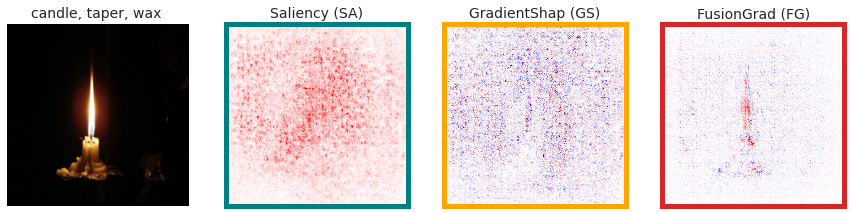

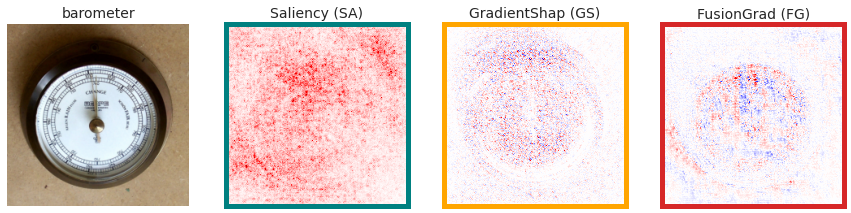

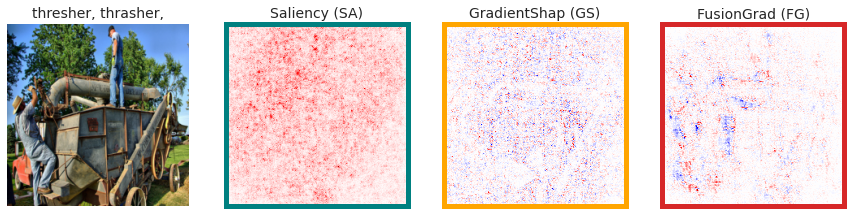

In [ ]:
# Plotting configs.
colours_order = ["#008080", "#FFA500", "#d62728"]
methods_order = ["Saliency (SA)", "GradientShap (GS)", "FusionGrad (FG)"]

plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False

# Plot explanations!
index = 1
ncols = 1 + len(attrs)

for index in [1, 10, 6]:
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, int(ncols)*3))

    for i in range(ncols):

        if i == 0:
            with warnings.catch_warnings():
                image = (np.moveaxis(quantus.denormalise(x_batch[index], 
                                                         mean=np.array([0.485, 0.456, 0.406]),
                                                         std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8)
                axes[0].imshow(image, vmin=0.0, vmax=1.0)
                axes[0].set_title(f"{CLASSES[y_batch[index]][:19]}", fontsize=14)
                axes[0].axis("off")
        else:
            
            xai = methods_order[i-1].split("(")[0].replace(" ", "").replace("\n", "")
            axes[i].imshow(quantus.normalise_by_negative(attrs[xai][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
            axes[i].set_title(f"{methods_order[i-1]}", fontsize=14)

            # Frame configs.
            axes[i].xaxis.set_visible([])
            axes[i].yaxis.set_visible([])
            axes[i].spines["top"].set_color(colours_order[i-1])
            axes[i].spines["bottom"].set_color(colours_order[i-1])
            axes[i].spines["left"].set_color(colours_order[i-1])
            axes[i].spines["right"].set_color(colours_order[i-1])
            axes[i].spines["top"].set_linewidth(5)
            axes[i].spines["bottom"].set_linewidth(5)
            axes[i].spines["left"].set_linewidth(5)
            axes[i].spines["right"].set_linewidth(5)

    plt.show()

From this visualisation, it is hard a decipher which explanation method may be preferred.

<a name="quantus"></a>
## 4) Introduction to Quantus

[Quantus](https://github.com/understandable-machine-intelligence-lab/Quantus) is a XAI Python open-source framework to evaluate the performance of neural network explanations. 

More details can found in at the offical [GitHub repository](https://github.com/understandable-machine-intelligence-lab/Quantus), [Getting Started Guide](https://quantus.readthedocs.io/en/latest/getting_started/getting_started_example.html) or [API documentation](https://quantus.readthedocs.io/en/latest/).

In [ ]:
import quantus

<a name="metrics"></a>
### 4.1 XAI metrics

In the following section, we demonstrate how to use Quantus to evaluate the different explanation methods under various explanation qualities — and their underlying metrics. In the following, we describe each of the categories briefly. The direction of the arrow indicates whether higher or lower values are considered better (exceptions within each category exist, so please carefully read the docstrings of each individual metric prior to usage and/or interpretation). For more complete description of the different properties, please see the official [Github repository](https://github.com/understandable-machine-intelligence-lab/Quantus/).

* **Faithfulness** (↑) quantifies to what extent explanations follow the predictive behaviour of the model, asserting that more important features affect model decisions more strongly e.g., <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140">(Bach et al., 2015)</a>, <a href="https://arxiv.org/pdf/2202.00449.pdf">(Rong, Leemann, et al., 2022)</a> and <a href="https://arxiv.org/abs/2202.00734">(Dasgupta et al., 2022)</a>.


$$\Psi_\text{F}(\Phi, f, \mathbf{x}, \mathcal{P}, M) = |(f(x) -f(\mathcal{P}_{\mathbb{X}}(\mathbf{x}, M))|.$$

* **Robustness** (↓) measures to what extent explanations are stable when subject to slight perturbations in the input, assuming that the model output approximately stayed the same e.g., </b><a href="https://arxiv.org/pdf/1806.08049.pdf">(Alvarez-Melis et al., 2018)</a>, </b><a href="https://arxiv.org/pdf/1901.09392.pdf">(Yeh et al., 2019)</a> and )</b><a href="https://arxiv.org/pdf/2203.06877.pdf"> (Agarwal, et. al., 2022)</a>.

$$\Psi_\text{RO}(\Phi, f, \mathbf{x}, \hat{y}, \mathcal{P}) = || \hat{\mathbf{e}}-\Phi(\mathcal{P}_{\mathbb{X}}(\mathbf{x}), f, \hat{y}; \lambda)|| \le \varepsilon.$$

* **Randomisation** (↑, ↓) tests to what extent explanations deteriorate as the data labels or the model, e.g., its parameters are increasingly randomised <a href="https://arxiv.org/abs/1810.03292">(Adebayo et. al., 2018)</a> and <a href="https://arxiv.org/abs/1912.09818">(Sixt et al., 2020)</a>.

$$\Psi_\text{RA}(\Phi, f, \mathbf{x}, \hat{y}, \mathcal{P}, \varepsilon) = ||  \hat{\mathbf{e}} - \Phi(\mathbf{x}, \mathcal{P}_{\mathbb{F}}(\theta), \hat{y}; \lambda) || \gg \varepsilon.$$

* **Localisation** (↑) tests if the explainable evidence is centred around a region of interest, which may be defined around an object by a bounding box, a segmentation mask or a cell within a grid e.g., <a href="https://arxiv.org/abs/1608.00507">(Zhang et al., 2018)</a>, </b><a href="https://arxiv.org/abs/2003.07258">(Arras et al., 2021)</a> and <a href="https://arxiv.org/abs/2109.15035">(Arias et al., 2022)</a>.

$$\Psi_\text{L}( \hat{\mathbf{e}}, \mathbf{s}^{gt}) = \frac{ \hat{\mathbf{e}}\cap \mathbf{s}^{gt}}{ \hat{\mathbf{e}}\cup \mathbf{s}^{gt}}$$

* **Complexity** (↓) captures to what extent explanations are concise, i.e., that few features are used to explain a model prediction e.g., <a href="https://arxiv.org/abs/1810.06583">(Chalasani et al., 2020)</a> and <a href="https://arxiv.org/abs/2005.00631">(Bhatt et al., 2020)</a>.

$$\Psi_\text{C}  = \mathbb{E}_i\left[-\ln \left(\mathbb{P}_{\Phi}\right)\right]=-\sum_{i=1}^D \mathbb{P}_{\Phi}(i) \ln \left(\mathbb{P}_{\Phi}(i)\right)  \\ \text{with}  \quad \mathbb{P}_{\Phi}(i)=\frac{\left|\Phi_i(\mathbf{x}, f, \hat{y} ;\lambda)\right|}{\sum_{j \in[d]}\left|\Phi_j(\mathbf{x}, f, \hat{y} ;\lambda)\right|} ; \mathbb{P}_{{\Phi}}=\left\{\mathbb{P}_{{\Phi}}(1), \ldots, \mathbb{P}_{{\Phi}}(d)\right\}, $$



In [ ]:
# Check what metrics are at our disposal.
for k, v in quantus.AVAILABLE_METRICS.items():
    print(k)
    for i in v:
        print(f"\t• {i}")

Faithfulness
	• Faithfulness Correlation
	• Faithfulness Estimate
	• Pixel-Flipping
	• Region Segmentation
	• Monotonicity-Arya
	• Monotonicity-Nguyen
	• Selectivity
	• SensitivityN
	• IROF
	• ROAD
	• Infidelity
	• Sufficiency
Robustness
	• Continuity Test
	• Local Lipschitz Estimate
	• Max-Sensitivity
	• Avg-Sensitivity
	• Consistency
	• Relative Input Stability
	• Relative Output Stability
	• Relative Representation Stability
Localisation
	• Pointing Game
	• Top-K Intersection
	• Relevance Mass Accuracy
	• Relevance Rank Accuracy
	• Attribution Localisation 
	• AUC
	• Focus
Complexity
	• Sparseness
	• Complexity
	• Effective Complexity
Randomisation
	• Model Parameter Randomisation
	• Random Logit
Axiomatic
	• Completeness
	• NonSensitivity
	• InputInvariance


#### 4.1.1 Measure complexity

We select one single metric within the complexity category of explanation quality. Sparseness <a href="https://arxiv.org/abs/1810.06583">(Chalasani et al., 2020)</a> is quantified using the Gini Index applied to the vector of the absolute values of attributions $\hat{\mathbf{e}}$ of length $D$.

$$\Psi_\text{SP}(\hat{\mathbf{e}}) = \frac{\sum_{i=1}^{D}(2 i-D-1) \hat{\mathbf{e}}_{i}}{D \sum_{i=1}^{D} \hat{\mathbf{e}}_{i}}$$



In [ ]:
# Let's try initialising one Complexity metric, called Sparseness.
quantus.Sparseness().get_params

Warnings and information:
 (1) The Sparseness metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Chalasani, Prasad, et al. Concise explanations of neural networks using adversarial training.' International Conference on Machine Learning. PMLR, (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



{'abs': True,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 'normalise_func_kwargs': {},
 'disable_warnings': False,
 'display_progressbar': False,
 'a_axes': None}


As a starter, we evaluate `Saliency` explanation [(Mørch et al., 1995](https://ieeexplore.ieee.org/document/488997/);
[Baehrens et al., 2010](https://www.jmlr.org/papers/volume11/baehrens10a/baehrens10a.pdf))

In [ ]:
# Alternative 1. Evaluate the Saliency explanations in a one-liner - by calling the intialised metric.
quantus.Sparseness()(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=attrs["Saliency"])

Warnings and information:
 (1) The Sparseness metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Chalasani, Prasad, et al. Concise explanations of neural networks using adversarial training.' International Conference on Machine Learning. PMLR, (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.37506366850801476,
 0.4489759915611668,
 0.40647525470421036,
 0.39181083301736036,
 0.40432383973619723,
 0.40417687567941424,
 0.37821202816679345,
 0.40406948047868363,
 0.4024801081008199,
 0.4142465252077391,
 0.40064664750138235,
 0.38582156191330136,
 0.42922009600219824,
 0.4034306436953608,
 0.3974940443849997]

In [ ]:
# Change some hyperparameters, get an aggregate score over several test samples.
quantus.Sparseness(return_aggregate=True, disable_warnings=True)(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=attrs["Saliency"])

[0.4030965065771762]

We evaluate `GradientShap` explanation ([Lundberg and Lee, 2017](https://arxiv.org/abs/1705.07874)).

In [ ]:
# Change the explanation method to evaluate Sparseness on GradientShap.
quantus.Sparseness(return_aggregate=True, disable_warnings=True)(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=attrs["GradientShap"])

[0.5522644427003834]


We evaluate `FusionGrad` FusionGrad ([Bykov et al., 2021](https://arxiv.org/abs/2106.10185) explanation.

In [ ]:
# Change the explanation method to evaluate Sparseness on FusionGrad.
quantus.Sparseness(return_aggregate=True, disable_warnings=True)(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=attrs["FusionGrad"])

[0.532326503387651]

In [ ]:
# Score all methods iteratively.
for method, attr in attrs.items():
    metric = quantus.Sparseness(return_aggregate=False, disable_warnings=True)
    scores = metric(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=attr)
    print(f" {method} - {np.mean(scores):.2f} ({np.std(scores):.2f})")

 Saliency - 0.40 (0.02)
 GradientShap - 0.55 (0.03)
 FusionGrad - 0.53 (0.02)


To structure the analysis a bit futher, you can leverage the built-in functionality of `quantus.evaluate()`.


<a name="large-scale"></a>
### 4.2 Large-scale evaluation

In the following, we use Quantus to quantiatively assess the different explanation methods on various evaluation criteria.

In [ ]:
# Initialise the Quantus evaluation metrics.
metrics = {
    "Robustness": quantus.MaxSensitivity(
        nr_samples=10,
        lower_bound=0.2,
        norm_numerator=quantus.norm_func.fro_norm,
        norm_denominator=quantus.norm_func.fro_norm,
        perturb_func=quantus.perturb_func.uniform_noise,
        similarity_func=quantus.similarity_func.difference,
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Faithfulness": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="black",
        perturb_func=quantus.baseline_replacement_by_indices,
        similarity_func=quantus.similarity_func.correlation_pearson,
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Localisation": quantus.RelevanceRankAccuracy(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Complexity": quantus.Sparseness(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Randomisation": quantus.ModelParameterRandomisation(
        layer_order="independent",
        similarity_func=quantus.similarity_func.correlation_spearman,
        return_sample_correlation=True,
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
}

# Define XAI methods to score.
xai_methods ={"Saliency": quantus.explain, "GradientShap": quantus.explain, "FusionGrad": fusiongrad_explainer} 

In [ ]:
# Run full quantification analysis!
def evaluate_xai_methods(metrics: dict, 
                         xai_methods: dict, 
                         x_batch: np.ndarray, 
                         y_batch: np.ndarray, 
                         s_batch: np.ndarray, 
                         nr_samples: int = 5):
    """Evaluate explanations."""
    results = {}
    for method, explainer in xai_methods.items():
        results[method] = {}
        for metric, metric_func in metrics.items():
            print(f"Evaluating the {metric} of {method} method...")
            # Get scores and append results.
            scores = metric_func(
                model=model,
                x_batch=x_batch[:nr_samples],
                y_batch=y_batch[:nr_samples],
                a_batch=None,
                s_batch=s_batch[:nr_samples],
                explain_func=explainer,
                explain_func_kwargs={"method": method})
            results[method][metric] = scores #results[method][metric] = np.random.random(size=nr_test_samples)


load_obj = True

if not load_obj:
    # Evaluate XAI methods.
    results = evaluate_xai_methods(metrics,
                         xai_methods,
                         x_batch,
                         y_batch,
                         s_batch)
else:
    # Retrieve stored data.
    results = {
        "Saliency": {
            "Robustness": [0.023706467548275694],
            "Faithfulness": [0.06749252841918861],
            "Localisation": [0.5122173871263156],
            "Complexity": [0.5503504513474646],
            "Randomisation": [0.8064057449830752],
        },
        "GradientShap": {
            "Robustness": [0.034456219962414575],
            "Faithfulness": [0.04583139237937677],
            "Localisation": [0.5046252238901434],
            "Complexity": [0.6088842825604118],
            "Randomisation": [0.7366918283019923],
        },
        "FusionGrad": {
            "Robustness": [0.02690529538428082],
            "Faithfulness": [-0.08233498797221532],
            "Localisation": [0.5071891576864163],
            "Complexity": [0.6107274870736773],
            "Randomisation": [0.7915174357470123],
        },
    }


Postprocessing of scores, computing how the different explanation methods rank across criteria.

In [ ]:
# Postprocessing of scores: to get how the different explanation methods rank across criteria.
results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()
df

,Robustness,Faithfulness,Localisation,Complexity,Randomisation
Saliency,0.023706,0.067493,0.512217,0.550350,0.806406
GradientShap,0.034456,0.045831,0.504625,0.608884,0.736692
FusionGrad,0.026905,0.082335,0.507189,0.610727,0.791517


To compare the different XAI methods, we normalise the metric scores between $[0, 1]$ and rank the scores from lowest to highest (i.e. the highest rank corresponds to best performance).

In [ ]:
# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, ~df.columns.isin(['Robustness', 'Randomisation'])].apply(lambda x: x / x.max())
df_normalised["Robustness"] = df["Robustness"].min()/df["Robustness"].values
df_normalised["Randomisation"] = df["Randomisation"].min()/df["Randomisation"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Faithfulness,Localisation,Complexity,Robustness,Randomisation
Saliency,2.0,3.0,1.0,3.0,1.0
GradientShap,1.0,1.0,2.0,1.0,3.0
FusionGrad,3.0,2.0,3.0,2.0,2.0


In [ ]:
#@title 4.2.1 Create spyder plot
%%capture

# Plotting specifics.
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Plotting configs.
sns.set(font_scale=1.5)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

# Source code: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html.

def spyder_plot(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    
    return theta

In [ ]:
#colours_order = ["red", "darkorange", "royalblue", "darkgreen", "slateblue", "purple"]

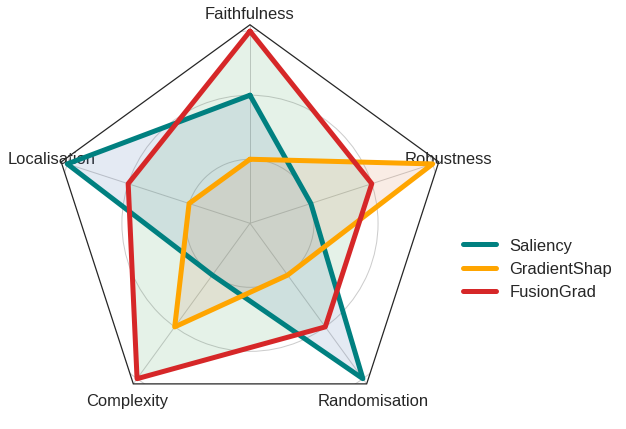

In [ ]:
# Make spyder graph!
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = spyder_plot(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods)):
    line = ax.plot(theta, d, label=method, color=colours_order[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness', 'Localisation', '\nComplexity', '\nRandomisation', 'Robustness'])
else:
    ax.set_varlabels(labels=[]) 

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[]) 

# Set a title.
#ax.set_title("Quantus: Summary of Explainer Quantification",  position=(0.5, 1.1), ha='center', fontsize=20)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

<a name="metaquantus"></a>
## 5) Introduction to MetaQuantus


[MetaQuantus](https://github.com/understandable-machine-intelligence-lab/Quantus) is an open-source, development tool for XAI researchers and Machine Learning (ML) practitioners to verify and benchmark newly constructed metrics (i.e., ``quality estimators''). It includes:

- A series of pre-built tests such as `ModelPerturbationTest` and `InputPertubrationTest` that can be applied to various metrics
- Supporting source code such as for plotting and analysis
- Various tutorials e.g., [Getting-Started-with-MetaQuantus](https://github.com/annahedstroem/MetaQuantus/blob/main/tutorials/Tutorial-Getting-Started-with-MetaQuantus.ipynb) and [Reproduce-Paper-Experiments](https://github.com/annahedstroem/MetaQuantus/blob/main/tutorials/Tutorial-Reproduce-Experiments.ipynb)

More details can found in at the offical [GitHub repository](https://github.com/annahedstroem/MetaQuantus).



In [ ]:
import metaquantus

<a name="estimators"></a>
### 5.1 Load estimators

In [ ]:
# Define a set of estimators using Quantus, a broader set of Localisation metrics.
estimators_localisation = {
    "Localisation": {
            "Pointing-Game": (
                quantus.PointingGame(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                False,
            ),
             "Top-K Intersection": (quantus.TopKIntersection(
                k=10,
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), False),
             "Relevance Rank Accuracy": (quantus.RelevanceRankAccuracy(
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), False),
            "Relevance Mass Accuracy": (
                quantus.RelevanceMassAccuracy(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                False,
            ),
        }
    }

<a name="test-suite"></a>
### 5.2 Define test suite

We define the Input Perturbation Test and Model Perturbation Test in order to evaluate the estimators.

In [ ]:
# Define test suite.
test_suite = {
        "Model Resilience Test": metaquantus.ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 0.001,
                "type": "Resilience",
            }
        ),
        "Model Adversary Test": metaquantus.ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 2.0,
                "type": "Adversary",
            }
        ),
        "Input Resilience Test": metaquantus.InputPerturbationTest(
            **{
                "noise": 0.001,
                "type": "Resilience",
            }
        ),
        "Input Adversary Test": metaquantus.InputPerturbationTest(
            **{
                "noise": 5.0,
                "type": "Adversary",
            }
        ),
    }

<a name="me-methods"></a>
### 5.3 Meta-evaluate methods

In [ ]:
load_obj = True

if not load_obj:

    # Set configs.
    iters = 5
    K = 10

    # Define the meta-evaluation exercise.
    meta_evaluator = metaquantus.MetaEvaluation(
        test_suite=test_suite,
        xai_methods={"Saliency": {}, "GradientShap": {}},
        iterations=iters,
        nr_perturbations=K,
        write_to_file=False,
    )

    # Collect the settings for the dataset.
    dataset_settings = {}
    dataset_settings["ImageNet"] = {
        "x_batch": x_batch,
        "y_batch": y_batch,
        "s_batch": s_batch,
        "models": {
            "ResNet18": model,
        },
        "gc_layers": {
            "ResNet18": "list(model.named_modules())[61][1]",
        },
        "estimator_kwargs": {
            "num_classes": 1000,
            "img_size": 224,
            "features": 224 * 4,
            "percentage": 0.1,
            "nr_channels": 3,
            "patch_size": 224 * 2,
            "perturb_baseline": "uniform",
        },
    }

    # Benchmark localisation metrics, using the intialised meta-evaluator.
    benchmark = metaquantus.MetaEvaluationBenchmarking(
        master=meta_evaluator,
        estimators=estimators_localisation,
        experimental_settings=dataset_settings,
        write_to_file=False,
        keep_results=True,
        channel_first=True,
        softmax=False,
        device=device,
    )()
else:
    !gdown https://drive.google.com/drive/folders/1uOjuMtbNkvLPqXrbozVjsDNeCxZ6peqs --folder --quiet
    !ls

# Load the benchmarking data for each model.
dataset_name = "ImageNet"
f_loc = [f.split("transformer_data/")[1] for f in glob.glob("transformer_data/*") if "localisation" in f]
batches = len(f_loc)

benchmarks_loc = {}
for model in ["ResNet18"]:
    benchmarks_loc[model] = {}
    for batch, f in enumerate(f_loc):
        benchmarks_loc[model][batch] = metaquantus.load_obj("transformer_data/", fname=f"{f}", use_json=True)[dataset_name][model]

assets	sample_data  transformer_data


In [ ]:
#@title 5.3.1 Plotting functionality
%%capture
from typing import Dict

def plot_multiple_models_estimator_area(
        benchmarks: Dict,
        estimators: Dict,
        dataset_name: str,
        colours: Dict,
        save: bool,
        path: str,
        average_over: list = ["Model", "Input"],
        **kwargs
) -> None:
    """
    Plot the outcome of the benchmarking exercise for different models.

    Parameters
    ----------
    benchmark: dict of dicts
        The benchmarking data, keys are the model names.
    estimators: dict
        The estimators used in the experiment.
    dataset_name: str
        The name of the dataset.
    colours: dict
        Dictionary of colours, based on the metrics.
    save: boolean
        Indicates if plots should be saved.
    path: str
        The path for saving the plot.
    average_over: list
        A list of spaces to average over.
    kwargs: dict
        A dict with plotting kwargs.

    Returns
    -------
    None
    """
    n_rows = kwargs.get("n_rows", 2)
    n_cols = kwargs.get("n_cols", 5)
    batches = kwargs.get("batches", 5)
    figsize = kwargs.get("figsize", (20, 8))

    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, figsize=figsize)

    models = list(benchmarks.keys())
    metrics = list(estimators.values())[0]
    estimator_category = list(estimators.keys())[0]

    for mx1, model_name in enumerate(models):
        for ex1, estimator_name in enumerate(metrics):
            mc_scores = []
            for px, perturbation_type in enumerate(["Input", "Model"]):
                scores = {"IAC_NR": [], "IAC_AR": [], "IEC_NR": [], "IEC_AR": []}
                for batch in range(batches):
                    # Collect scores.
                    scores["IAC_NR"].append(np.array(
                        benchmarks[model_name][batch][estimator_category][estimator_name][
                            "results_consistency_scores"
                        ][perturbation_type]["intra_scores_res"]
                    ))
                    scores["IAC_AR"].append(np.array(
                        benchmarks[model_name][batch][estimator_category][estimator_name][
                            "results_consistency_scores"
                        ][perturbation_type]["intra_scores_adv"]
                    ))
                    scores["IEC_NR"].append(np.array(
                        benchmarks[model_name][batch][estimator_category][estimator_name][
                            "results_consistency_scores"
                        ][perturbation_type]["inter_scores_res"]
                    ))
                    scores["IEC_AR"].append(np.array(
                        benchmarks[model_name][batch][estimator_category][estimator_name][
                            "results_consistency_scores"
                        ][perturbation_type]["inter_scores_adv"]
                    ))

                for k, v in scores.items():
                    scores[k] = np.array(scores[k]).flatten()

                # Set values for m* and the actual values by the estimator.
                X_gt = [-1, 0, 1, 0]
                Y_gt = [0, 1, 0, -1]
                X_area = [-scores["IAC_AR"].mean(), 0, scores["IEC_AR"].mean(), 0]
                Y_area = [0, scores["IAC_NR"].mean(), 0, -scores["IEC_NR"].mean()]

                # Set the spaces to average the MC value over.
                if perturbation_type in average_over:
                    mc_score = np.mean(
                        [
                            scores["IAC_NR"].mean(),
                            scores["IEC_NR"].mean(),
                            scores["IAC_AR"].mean(),
                            scores["IEC_AR"].mean(),
                        ]
                    )
                    mc_scores.append(mc_score)

                if perturbation_type == "Input":
                    axs[ex1].fill(
                        X_area,
                        Y_area,
                        color=colours[estimator_name],
                        alpha=0.75,
                        label=perturbation_type,
                        edgecolor="black",
                    )
                else:
                    axs[ex1].fill(
                        X_area,
                        Y_area,
                        color=colours[estimator_name],
                        alpha=0.5,
                        label=perturbation_type,
                        hatch="/",
                        edgecolor="black",
                    )

                # Plot m*.
                if px == 1:
                    axs[ex1].fill(
                        X_gt, Y_gt, color="black", alpha=0.075, label="m*"
                    )

                # Annotate the labels.
                axs[ex1].annotate("${IAC}_{AR}$", (-1, 0), fontsize=12)
                axs[ex1].annotate("${IAC}_{NR}$", (-0.2, 0.8), fontsize=12)
                axs[ex1].annotate("${IEC}_{AR}$", (0.7, 0), fontsize=12)
                axs[ex1].annotate("${IEC}_{NR}$", (-0.2, -0.8), fontsize=12)

            # Labels.
            axs[ex1].set_xticklabels(
                ["", "1", "0.5", "0", "0.5", "1"], fontsize=14
            )
            axs[ex1].set_yticklabels(
                ["", "1", "", "0.5", "", "0", "", "0.5", "", "1", ""], fontsize=14
            )

            if ex1 == 0:
                axs[ex1].set_ylabel(model_name, fontsize=14)

            if estimator_name == "Model Parameter Randomisation Test":
                estimator_name = "Model Parameter Random."

            # Title and grids.
            axs[ex1].set_title(
                f"{estimator_name} ({np.array(mc_scores).flatten().mean():.4f})",
                fontsize=15,
            )
            axs[ex1].grid()
            axs[ex1].legend(loc="upper left")
            plt.grid()

    plt.tight_layout()
    if save:
        plt.savefig(path + "plots/" + f"full_area_graph_{estimator_category}_{dataset_name}_multiple_models.png", dpi=500)
    plt.show()


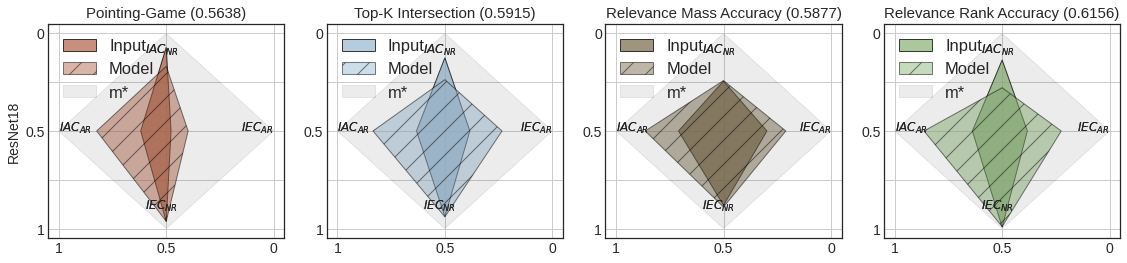

In [ ]:
# Plotting settings.
estimators = {"Localisation": ["Pointing-Game", "Top-K Intersection", "Relevance Mass Accuracy", "Relevance Rank Accuracy"],}
colours = {
    'Pointing-Game': "#b66a50",
    'Top-K Intersection': "#9dbcd4",
    'Relevance Mass Accuracy': "#7f7053",
    'Relevance Rank Accuracy': "#8fb67b",
 }
kwargs = {"n_rows": 1, "n_cols": len(list(estimators.values())[0]), "batches": batches}
kwargs["figsize"] = (kwargs["n_cols"]*4, kwargs["n_rows"]*4)

# Plot!
plot_multiple_models_estimator_area(benchmarks=benchmarks_loc, estimators=estimators, dataset_name=dataset_name, colours=colours, save=False, path="", **kwargs);

<a name="references"></a>
## 6) References

* [Quantus: An Explainable AI Toolkit for Responsible Evaluation of Neural Network Explanations and Beyond](https://jmlr.org/papers/v24/22-0142.html) by Hedström et al., 2022
* [The Meta-Evaluation Problem in Explainable AI:
Identifying Reliable Estimators with MetaQuantus](https://arxiv.org/abs/2302.07265) by Hedström et al., 2023
* [NoiseGrad — Enhancing Explanations by Introducing Stochasticity to Model Weights](https://ojs.aaai.org/index.php/AAAI/article/view/20561) by Bykov et al, 2022